In [1]:
!pip freeze | grep scikit

scikit-image==0.19.3
scikit-learn==1.2.2


In [2]:
from google.cloud import bigquery
from google.colab import auth, drive
import os
# Mount to Google Drive if data on Drive
drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/COMP90089/COMP90089 Team 13')
os.getcwd()

Mounted at /content/gdrive


'/content/gdrive/.shortcut-targets-by-id/1ilKwwgquZsK5UDJS2DgoYs_1OJbWKzYZ/COMP90089 Team 13'

In [3]:
from typing import Callable
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import warnings

warnings.filterwarnings('ignore')

In [4]:
class NBClassifier:
  r'''Because sklearn people doesn't do missing value handle'''
  def fit(self, X, y):
      r'''Form the normal distribution of each feature'''
      self.X=X
      self.y=y
      self.classes = np.unique(y)
      self.parameters = {}
      for i, c in enumerate(self.classes):
          X_class = X.loc[y == c]
          self.parameters[c] = []
          for col in X_class.columns:
              parameters = {"mean": X_class[col].mean(skipna=True),
                            "var" : X_class[col].var(skipna=True)}
              self.parameters[c].append(parameters)
      return self

  def _calculate_likelihood(self, mean, var, x):
      '''Get likelihood of an instance based on Gaussian'''
      if var == 0:
          if x == mean:
              return 1
          else:
              return 0
      else:
          exponent = np.exp(-((x - mean) ** 2) / (2 * var))
          return (1 / (np.sqrt(2 * np.pi * var))) * exponent

  def _calculate_prior(self, c, y):
      return np.mean(y == c)

  def predict(self, X):
      '''Use the given likelihoods to get the final prediction'''
      predictions = []
      for _, x in X.iterrows():
          posteriors = []
          for idx, c in enumerate(self.classes):
              prior = self._calculate_prior(c, self.y)
              posterior = prior
              for i, param in enumerate(self.parameters[c]):
                  likelihood = self._calculate_likelihood(param["mean"], param["var"], x[i])
                  posterior *= likelihood
              posteriors.append(posterior)
          predictions.append(self.classes[np.argmax(posteriors)])
      return predictions


In [27]:
def classify_and_compare(clf: Callable, d, l,
                         test:float = 0.35,
                         verbose:int = 0,
                         print_res:bool = False,
                         df = None,
                         engineering:str = 'None',
                         disease:str = 'None'):
  r'''
  Compare data with and without additional MIMIC-IV Features

  Params
  ---
  - `clf`: The classifier initialization function (sklearn style)
  - `d`: dataset that contains both MIMIC-IV and image data features
  - `l`: label data
  - `test`: test split ratio
  - `verbose`: If you want to print out the progress in the classfier while fitting
  - `print_res`: If result is to be printed or exported to a dataframe column
  - `df`: the dataframe to append results to if not printing
  - `engineering`: Specify if any data engineering is done
  - `disease`: Name of the disease being classified
  '''
  # Split to train and test
  xtr, xte, ytr, yte = train_test_split(d, l, test_size=test)

  # c1: With all features
  b = clf().fit(xtr,ytr)
  p = b.predict(xte)
  c1 = classification_report(yte, p, output_dict = not print_res)

  # c2: Image features only
  b = clf().fit(xtr[img_feats],ytr)
  p = b.predict(xte[img_feats])
  c2 = classification_report(yte, p, output_dict = not print_res)

  # c3: Original structure: a linear layer with sigmoid activation on image features
  b = LogisticRegression().fit(xtr[img_feats],ytr)
  p = b.predict(xte[img_feats])
  c3 = classification_report(yte, p, output_dict = not print_res)

  # Either print result or append to dataframe
  if print_res:
    print(c1 + '\n' + c2 + '\n' + c3)
  else:
    col = pd.Series({'Model': clf.__name__,
                     'Engineering': engineering,
                     'Disease': disease,
                     # Accuracy
                     'acc_e': c1['accuracy'],
                     'acc_o': c2['accuracy'],
                     'acc_d': c1['accuracy'] - c2['accuracy'],
                     'acc_i': c2['accuracy'] - c3['accuracy'],
                     'acc_x': c1['accuracy'] - c3['accuracy'],
                     # Precision for negative
                     'p0_e': c1['0']['precision'],
                     'p0_o': c2['0']['precision'],
                     'p0_d': c1['0']['precision'] - c2['0']['precision'],
                     # Precision for positive
                     'p1_e': c1['1']['precision'],
                     'p1_o': c2['1']['precision'],
                     'p1_d': c1['1']['precision'] - c2['1']['precision'],
                     'p1_i': c2['1']['precision'] - c3['1']['precision'],
                     'p1_x': c1['1']['precision'] - c3['1']['precision'],
                     # Recall for negative
                     'r0_e': c1['0']['recall'],
                     'r0_o': c2['0']['recall'],
                     'r0_d': c1['0']['recall'] - c2['0']['recall'],
                     # Recall for positive
                     'r1_e': c1['1']['recall'],
                     'r1_o': c2['1']['recall'],
                     'r1_d': c1['1']['recall'] - c2['1']['recall'],
                     'r1_i': c2['1']['recall'] - c3['1']['recall'],
                     'r1_x': c1['1']['recall'] - c3['1']['recall']})
    df[len(df.columns)] = col



In [39]:
# Read in data and list the necessary features
df = pd.read_csv('x_ray_and_features_data.csv')

diseases = ['pneumonia', 'tuberculosis', 'bronchitis', 'arthritis', 'fracture', 'lung_cancer', 'scoliosis', 'lung_infection']
mimic_feats = ['diabete', 'age', 'hiv', 'oxygen', 'heart_rate', 'temperature', 'hemoglobin', 'rbc', 'wbc', 'smoke', 'cough']
img_feats = [str(x) for x in range(18)]

In [40]:
# List out the models
models = [XGBClassifier, NBClassifier]
# Keep the necessary data
data = df[img_feats+mimic_feats]

In [41]:
# Number of times run per model
n_iter = 5
# Desired test size
test_size = 0.35
res = pd.DataFrame()

# For each group of disease and model, perform n comparison runs
for d in tqdm.tqdm(diseases):
  l = df[d]
  for m in models:
    for i in range(n_iter):
      classify_and_compare(m, data, l, test_size, df=res, engineering='None', disease=d)

res.T

100%|██████████| 8/8 [15:09<00:00, 113.75s/it]


,Model,Engineering,Disease,acc_e,acc_o,acc_d,acc_i,acc_x,p0_e,p0_o,...,p1_i,p1_x,r0_e,r0_o,r0_d,r1_e,r1_o,r1_d,r1_i,r1_x
0,XGBClassifier,None,pneumonia,0.781788,0.700561,0.081227,-0.022421,0.058806,0.7931,0.728527,...,-0.400667,-0.038136,0.94449,0.933605,0.010884,0.357574,0.092941,0.264633,0.091877,0.356509
1,XGBClassifier,None,pneumonia,0.790147,0.709706,0.080441,-0.019471,0.06097,0.803985,0.73531,...,-0.392029,-0.040713,0.941724,0.94024,0.001484,0.382438,0.089623,0.292816,0.088534,0.38135
2,XGBClassifier,None,pneumonia,0.781984,0.69997,0.082014,-0.022618,0.059396,0.795235,0.727013,...,-0.261952,0.104254,0.940384,0.936301,0.004083,0.369596,0.084692,0.284904,0.083629,0.368533
3,XGBClassifier,None,pneumonia,0.787786,0.704986,0.082801,-0.023109,0.059691,0.802003,0.734084,...,0.011404,0.37112,0.940851,0.932748,0.008103,0.377713,0.09479,0.282923,0.094428,0.377352
4,XGBClassifier,None,pneumonia,0.784541,0.699479,0.085062,-0.023306,0.061756,0.798129,0.7276,...,-0.022893,0.34948,0.939761,0.934185,0.005575,0.379041,0.086323,0.292718,0.084547,0.377265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,NBClassifier,None,lung_infection,0.960173,0.967745,-0.007572,0.0,-0.007572,0.967963,0.967745,...,0.0,0.057471,0.991668,1.0,-0.008332,0.015244,0.0,0.015244,0.0,0.015244
76,NBClassifier,None,lung_infection,0.96332,0.965975,-0.002655,-0.003442,-0.006097,0.969415,0.969589,...,0.073171,0.030303,0.993508,0.996145,-0.002637,0.006431,0.009646,-0.003215,0.009646,0.006431
77,NBClassifier,None,lung_infection,0.951028,0.96332,-0.012292,-0.00295,-0.015242,0.965841,0.96617,...,0.0,0.006369,0.984124,0.996947,-0.012823,0.002915,0.0,0.002915,0.0,0.002915
78,NBClassifier,None,lung_infection,0.962337,0.970204,-0.007867,-0.000492,-0.008359,0.970542,0.970681,...,0.0,0.011494,0.991288,0.999493,-0.008206,0.003356,0.0,0.003356,0.0,0.003356


In [42]:
# Export results to the csv
results = res.T
results.to_csv('results_no_processing.csv',index=False)

Aggregare runs of the same result to get mean and standard deviation

In [43]:
# Get the mean
rmean = results.groupby(['Model','Engineering','Disease']).mean()
rmean.to_csv('results_no_processing_mean.csv')
rmean

acc_e     acc_o     acc_d  \
Model         Engineering Disease                                        
NBClassifier  None        arthritis       0.934645  0.958718 -0.024073   
                          bronchitis      0.941981  0.947881 -0.005900   
                          fracture        0.895821  0.897197 -0.001377   
                          lung_cancer     0.711712  0.597699  0.114013   
                          lung_infection  0.959465  0.966250 -0.006785   
                          pneumonia       0.732009  0.584227  0.147782   
                          scoliosis       0.989615  0.930062  0.059554   
                          tuberculosis    0.965444  0.949199  0.016245   
XGBClassifier None        arthritis       0.964480  0.958501  0.005979   
                          bronchitis      0.952050  0.946661  0.005389   
                          fracture        0.934802  0.927190  0.007611   
                          lung_cancer     0.780195  0.714623  0.065572   
                          lung_infection  0.971856  0.967666  0.004189   
                          pneumonia       0.785249  0.702940  0.082309   
                          scoliosis       0.995319  0.994080  0.001239   
                          tuberculosis    0.978877  0.973822  0.005055   

                                             acc_i     acc_x      p0_e  \
Model         Engineering Disease                                        
NBClassifier  None        arthritis      -0.000472 -0.024545  0.958964   
                          bronchitis     -0.000020 -0.005920  0.948889   
                          fracture       -0.031586 -0.032963  0.931975   
                          lung_cancer    -0.133504 -0.019491  0.730798   
                          lung_infection -0.001908 -0.008693  0.968043   
                          pneumonia      -0.140918  0.006864  0.731805   
                          scoliosis      -0.064903 -0.005350  0.994940   
                          tuberculosis   -0.022795 -0.006549  0.971925   
XGBClassifier None        arthritis      -0.000374  0.005605  0.964520   
                          bronchitis     -0.000787  0.004602  0.952957   
                          fracture       -0.001809  0.005802  0.936374   
                          lung_cancer    -0.016462  0.049110  0.794981   
                          lung_infection -0.000334  0.003855  0.971858   
                          pneumonia      -0.022185  0.060124  0.798490   
                          scoliosis       0.000000  0.001239  0.995313   
                          tuberculosis   -0.000275  0.004779  0.978926   

                                              p0_o      p0_d      p1_e  \
Model         Engineering Disease                                        
NBClassifier  None        arthritis       0.959170 -0.000206  0.026909   
                          bronchitis      0.947899  0.000990  0.315595   
                          fracture        0.929572  0.002403  0.137520   
                          lung_cancer     0.761486 -0.030688  0.263528   
                          lung_infection  0.968170 -0.000127  0.021128   
                          pneumonia       0.751876 -0.020070  0.773826   
                          scoliosis       0.995026 -0.000086  0.000000   
                          tuberculosis    0.972304 -0.000379  0.013742   
XGBClassifier None        arthritis       0.958878  0.005642  0.960013   
                          bronchitis      0.947548  0.005409  0.827537   
                          fracture        0.929057  0.007316  0.783271   
                          lung_cancer     0.737805  0.057175  0.683469   
                          lung_infection  0.968009  0.003850  0.971304   
                          pneumonia       0.730507  0.067983  0.707296   
                          scoliosis       0.994080  0.001233  1.000000   
                          tuberculosis    0.974109  0.004817  0.969326   

                                              

In [44]:
# Get the standard deviation
rsd = results.groupby(['Model','Engineering','Disease']).std()
rsd.to_csv('results_no_processing_std.csv')
rsd

acc_e     acc_o     acc_d  \
Model         Engineering Disease                                        
NBClassifier  None        arthritis       0.018314  0.002581  0.015888   
                          bronchitis      0.006155  0.002017  0.005596   
                          fracture        0.006180  0.015696  0.015714   
                          lung_cancer     0.008682  0.004529  0.010490   
                          lung_infection  0.004894  0.002809  0.003863   
                          pneumonia       0.003432  0.003420  0.003866   
                          scoliosis       0.004690  0.037659  0.036283   
                          tuberculosis    0.007011  0.018413  0.024127   
XGBClassifier None        arthritis       0.002157  0.002055  0.000420   
                          bronchitis      0.001074  0.001235  0.001051   
                          fracture        0.001339  0.000490  0.001014   
                          lung_cancer     0.003817  0.002108  0.002460   
                          lung_infection  0.000665  0.000987  0.000372   
                          pneumonia       0.003659  0.004371  0.001773   
                          scoliosis       0.000647  0.000562  0.000149   
                          tuberculosis    0.001760  0.002384  0.000647   

                                             acc_i     acc_x      p0_e  \
Model         Engineering Disease                                        
NBClassifier  None        arthritis       0.001055  0.016255  0.002198   
                          bronchitis      0.000044  0.005621  0.002127   
                          fracture        0.014681  0.004534  0.001992   
                          lung_cancer     0.005276  0.009592  0.001324   
                          lung_infection  0.001553  0.003783  0.001969   
                          pneumonia       0.004078  0.003705  0.003610   
                          scoliosis       0.037388  0.005064  0.000632   
                          tuberculosis    0.018089  0.007692  0.000777   
XGBClassifier None        arthritis       0.000213  0.000578  0.002206   
                          bronchitis      0.000361  0.000791  0.001201   
                          fracture        0.000345  0.001252  0.001276   
                          lung_cancer     0.001810  0.003120  0.004030   
                          lung_infection  0.000165  0.000447  0.000711   
                          pneumonia       0.001559  0.001208  0.004536   
                          scoliosis       0.000000  0.000149  0.000647   
                          tuberculosis    0.000176  0.000609  0.001807   

                                              p0_o      p0_d      p1_e  \
Model         Engineering Disease                                        
NBClassifier  None        arthritis       0.002080  0.000189  0.015707   
                          bronchitis      0.002014  0.000696  0.231343   
                          fracture        0.002064  0.000757  0.009223   
                          lung_cancer     0.002282  0.001822  0.039305   
                          lung_infection  0.001921  0.000206  0.023249   
                          pneumonia       0.004438  0.005467  0.095511   
                          scoliosis       0.000576  0.000151  0.000000   
                          tuberculosis    0.000754  0.000241  0.020388   
XGBClassifier None        arthritis       0.001955  0.000631  0.031684   
                          bronchitis      0.001037  0.000687  0.058424   
                          fracture        0.000217  0.001101  0.046348   
                          lung_cancer     0.001730  0.002972  0.008099   
                          lung_infection  0.001078  0.000374  0.030379   
                          pneumonia       0.003887  0.002160  0.003264   
                          scoliosis       0.000562  0.000149  0.000000   
                          tuberculosis    0.002309  0.000559  0.024407   

                                              

In [45]:
# Also get a result table that aggregates the mean and standard deviation
res_agg = rmean.combine(rsd, lambda x1,x2: x1.apply(lambda x: round(x,2)).astype(str) + '±' + x2.apply(lambda x: round(x,2)).astype(str))
res_agg.to_csv('results_no_processing_agg.csv')
res_agg

acc_e      acc_o       acc_d  \
Model         Engineering Disease                                            
NBClassifier  None        arthritis       0.93±0.02   0.96±0.0  -0.02±0.02   
                          bronchitis      0.94±0.01   0.95±0.0  -0.01±0.01   
                          fracture         0.9±0.01   0.9±0.02   -0.0±0.02   
                          lung_cancer     0.71±0.01    0.6±0.0   0.11±0.01   
                          lung_infection   0.96±0.0   0.97±0.0   -0.01±0.0   
                          pneumonia        0.73±0.0   0.58±0.0    0.15±0.0   
                          scoliosis        0.99±0.0  0.93±0.04   0.06±0.04   
                          tuberculosis    0.97±0.01  0.95±0.02   0.02±0.02   
XGBClassifier None        arthritis        0.96±0.0   0.96±0.0    0.01±0.0   
                          bronchitis       0.95±0.0   0.95±0.0    0.01±0.0   
                          fracture         0.93±0.0   0.93±0.0    0.01±0.0   
                          lung_cancer      0.78±0.0   0.71±0.0    0.07±0.0   
                          lung_infection   0.97±0.0   0.97±0.0     0.0±0.0   
                          pneumonia        0.79±0.0    0.7±0.0    0.08±0.0   
                          scoliosis         1.0±0.0   0.99±0.0     0.0±0.0   
                          tuberculosis     0.98±0.0   0.97±0.0    0.01±0.0   

                                               acc_i       acc_x      p0_e  \
Model         Engineering Disease                                            
NBClassifier  None        arthritis         -0.0±0.0  -0.02±0.02  0.96±0.0   
                          bronchitis        -0.0±0.0  -0.01±0.01  0.95±0.0   
                          fracture        -0.03±0.01   -0.03±0.0  0.93±0.0   
                          lung_cancer     -0.13±0.01  -0.02±0.01  0.73±0.0   
                          lung_infection    -0.0±0.0   -0.01±0.0  0.97±0.0   
                          pneumonia        -0.14±0.0    0.01±0.0  0.73±0.0   
                          scoliosis       -0.06±0.04  -0.01±0.01  0.99±0.0   
                          tuberculosis    -0.02±0.02  -0.01±0.01  0.97±0.0   
XGBClassifier None        arthritis         -0.0±0.0    0.01±0.0  0.96±0.0   
                          bronchitis        -0.0±0.0     0.0±0.0  0.95±0.0   
                          fracture          -0.0±0.0    0.01±0.0  0.94±0.0   
                          lung_cancer      -0.02±0.0    0.05±0.0  0.79±0.0   
                          lung_infection    -0.0±0.0     0.0±0.0  0.97±0.0   
                          pneumonia        -0.02±0.0    0.06±0.0   0.8±0.0   
                          scoliosis          0.0±0.0     0.0±0.0   1.0±0.0   
                          tuberculosis      -0.0±0.0     0.0±0.0  0.98±0.0   

                                              p0_o        p0_d       p1_e  \
Model         Engineering Disease                                           
NBClassifier  None        arthritis       0.96±0.0    -0.0±0.0  0.03±0.02   
                          bronchitis      0.95±0.0     0.0±0.0  0.32±0.23   
                          fracture        0.93±0.0     0.0±0.0  0.14±0.01   
                          lung_cancer     0.76±0.0   -0.03±0.0  0.26±0.04   
                          lung_infection  0.97±0.0    -0.0±0.0  0.02±0.02   
                          pneumonia       0.75±0.0  -0.02±0.01   0.77±0.1   
                          scoliosis        1.0±0.0    -0.0±0.0    0.0±0.0   
                          tuberculosis    0.97±0.0    -0.0±0.0  0.01±0.02   
XGBClassifier None        arthritis       0.96±0.0    0.01±0.0  0.96±0.03   
                          bronchitis      0.95±0.0    0.01±0.0  0.83±0.06   
                          fracture        0.93±0.0    0.01±0.0  0.78±0.05   
                          lung_cancer     0.74±0.0    0.06±0.0  0.68±0.01   
                          lung_infection  0.97±0.0     0.0±0.0  0.97±0.03   
                          pneumonia       0.73±0.0    0.07±0.0   0.71±0.0   
    

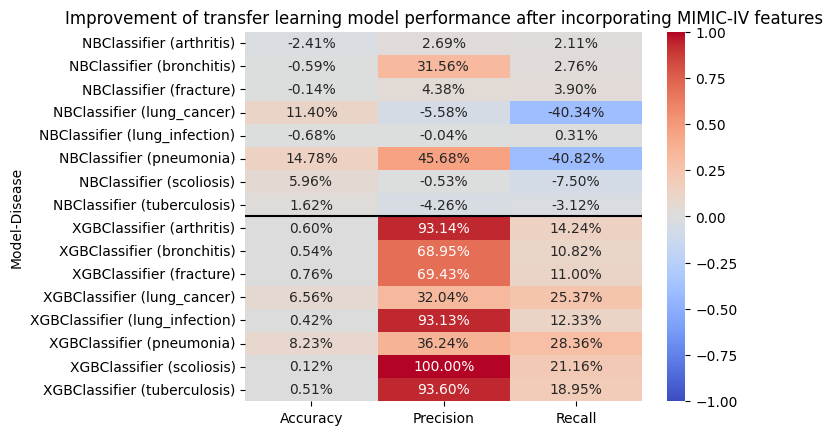

In [46]:
# String conversion to make display explainable
def mdl_fmt(s):
  ss = str(s).split('-')
  return f'{ss[0]} ({ss[2]})'

# We will look at positive accuracy, precision and recall
diffs = ['acc_d','p1_d','r1_d']
_,ax = plt.subplots()

# Plotting out
sns.heatmap(rmean[diffs], cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2%", ax=ax)
ax.set_title('Improvement of transfer learning model performance after incorporating MIMIC-IV features')
ax.set_xticks([0.5,1.5,2.5],['Accuracy', 'Precision', 'Recall'])
ax.set_yticklabels([mdl_fmt(item.get_text()) for item in ax.get_yticklabels()])
ax.set_ylabel('Model-Disease')
# Draw line to separate the models
ax.hlines([8], *ax.get_xlim(), colors='black')

plt.show()

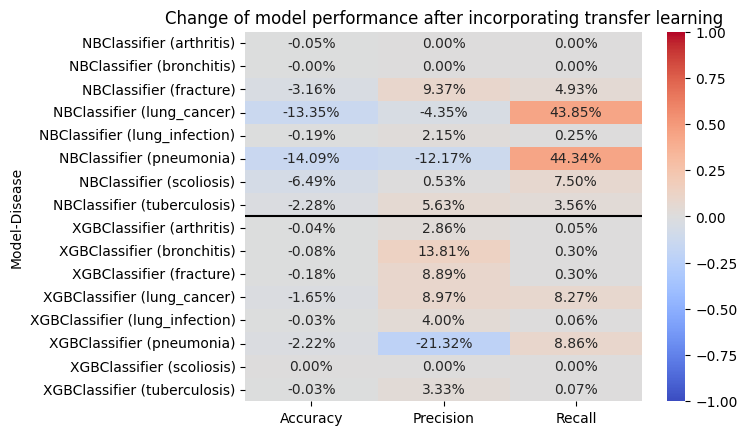

In [47]:
# We will look at positive accuracy, precision and recall
diffs = ['acc_i','p1_i','r1_i']
_,ax = plt.subplots()

# Plotting out
sns.heatmap(rmean[diffs], cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2%", ax=ax)
ax.set_title('Change of model performance after incorporating transfer learning')
ax.set_xticks([0.5,1.5,2.5],['Accuracy', 'Precision', 'Recall'])
ax.set_yticklabels([mdl_fmt(item.get_text()) for item in ax.get_yticklabels()])
ax.set_ylabel('Model-Disease')
# Draw line to separate the models
ax.hlines([8], *ax.get_xlim(), colors='black')

plt.show()

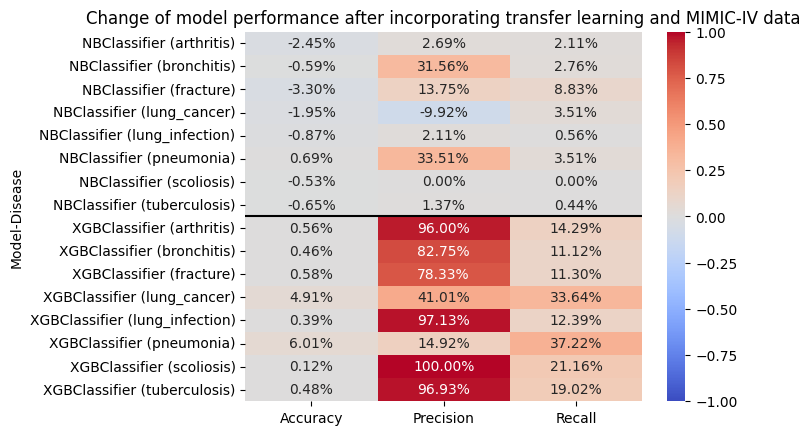

In [48]:
# We will look at positive accuracy, precision and recall
diffs = ['acc_x','p1_x','r1_x']
_,ax = plt.subplots()

# Plotting out
sns.heatmap(rmean[diffs], cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2%", ax=ax)
ax.set_title('Change of model performance after incorporating transfer learning and MIMIC-IV data')
ax.set_xticks([0.5,1.5,2.5],['Accuracy', 'Precision', 'Recall'])
ax.set_yticklabels([mdl_fmt(item.get_text()) for item in ax.get_yticklabels()])
ax.set_ylabel('Model-Disease')
# Draw line to separate the models
ax.hlines([8], *ax.get_xlim(), colors='black')

plt.show()